# 多层感知机的简洁实现
:label:`sec_mlp_concise`

本节将介绍(**通过高级API更简洁地实现多层感知机**)。


In [126]:
import torch
from torch import nn
from d2l import torch as d2l

## 模型

与softmax回归的简洁实现（ :numref:`sec_softmax_concise`）相比，
唯一的区别是我们添加了2个全连接层（之前我们只添加了1个全连接层）。
第一层是[**隐藏层**]，它(**包含256个隐藏单元，并使用了ReLU激活函数**)。
第二层是输出层。


In [127]:
net = nn.Sequential(nn.Conv2d(1, 4, 3, stride=2, padding=1), nn.ReLU(),
                    nn.Conv2d(4, 8, 3, stride=2, padding=1), nn.ReLU(),
                    nn.Flatten(),
                    nn.Linear(8 * 7 * 7, 64), nn.Sigmoid(),
                    nn.Linear(64, 10))


def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)


X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Conv2d output shape: 	 torch.Size([1, 4, 14, 14])
ReLU output shape: 	 torch.Size([1, 4, 14, 14])
Conv2d output shape: 	 torch.Size([1, 8, 7, 7])
ReLU output shape: 	 torch.Size([1, 8, 7, 7])
Flatten output shape: 	 torch.Size([1, 392])
Linear output shape: 	 torch.Size([1, 64])
Sigmoid output shape: 	 torch.Size([1, 64])
Linear output shape: 	 torch.Size([1, 10])


[**训练过程**]的实现与我们实现softmax回归时完全相同，
这种模块化设计使我们能够将与模型架构有关的内容独立出来。


In [128]:
net.apply(init_weights)

batch_size, lr, num_epochs = 64, 5e-2, 5
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=4e-4)

KeyboardInterrupt: 

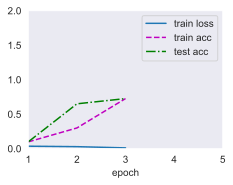

In [129]:
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)


def evaluate_accuracy(net, data_iter):
    """Compute the accuracy for a model on a dataset.

    Defined in :numref:`sec_softmax_scratch`"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
    metric = d2l.Accumulator(2)  # No. of correct predictions, no. of predictions
    device = next(iter(net.parameters())).device
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]


def train_epoch_ch3(net, train_iter, loss, updater,device=torch.device('mps')):
    """The training loop defined in Chapter 3.

    Defined in :numref:`sec_softmax_scratch`"""
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = d2l.Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        if isinstance(X, list):
            # Required for BERT Fine-tuning (to be covered later)
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # Using PyTorch in-built optimizer & loss criterion
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # Using custom built optimizer & loss criterion
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), d2l.accuracy(y_hat, y), y.numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]


def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater,device=torch.device('mps')):
    """Train a model (defined in Chapter 3).

    Defined in :numref:`sec_softmax_scratch`"""
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.0, 2],
                        legend=['train loss', 'train acc', 'test acc'])
    net.to(device)
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [ ]:
net.to(device=torch.device('cpu'))
d2l.predict_ch3(net, test_iter, 12)

## 小结

* 我们可以使用高级API更简洁地实现多层感知机。
* 对于相同的分类问题，多层感知机的实现与softmax回归的实现相同，只是多层感知机的实现里增加了带有激活函数的隐藏层。

## 练习

1. 尝试添加不同数量的隐藏层（也可以修改学习率），怎么样设置效果最好？
1. 尝试不同的激活函数，哪个效果最好？
1. 尝试不同的方案来初始化权重，什么方法效果最好？


[Discussions](https://discuss.d2l.ai/t/1802)
